In [1]:
from ete3 import Tree
import scanpy as sc
import networkx as nx
import numpy as np
import pandas as pd

from collections import defaultdict

import seaborn as sns
import os
import gseapy

import pickle as pic

import scipy.stats as scs

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.nan)

from utilities import de_utils
from utilities import tree_utilities

/home/mattjones/.local/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


# Read in 10X data

In [2]:
path = "/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/GRCh38/"
adata = sc.read(path + "matrix.mtx", cache=True).T
genes = pd.read_csv(path + "genes.tsv", header=None, sep='\t')
adata.var_names = genes[1]
adata.var['gene_ids'] = genes[0]  # add the gene ids as annotation of the variables/genes
adata.obs_names = pd.read_csv(path + 'barcodes.tsv', header=None)[0]
adata.var_names_make_unique()

all_genes = adata.var_names

# meta = pd.read_csv("data/5k.LG_meta.txt", sep='\t', index_col=0)
meta = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/JQ.5k.vision_meta.txt", sep='\t', index_col = 0)
latent = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/latent.csv", sep='\t', index_col = 0)
latent.index = adata.obs_names

umap = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/JQ19.5k.UMAP.txt", sep='\t', index_col = 0)

gene_list = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/RNA/ALL_Samples/filtered_genes.txt", sep='\t', header=None).iloc[:,0].values

adata.shape, latent.shape, meta.shape 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


((43423, 33694), (43423, 10), (35970, 10))

In [3]:
adata.obs = adata.obs.merge(meta, left_index = True, right_index=True, how="left")

meta_filter = np.logical_not(adata.obs["DynamicMetScore"].isna())
adata = adata[meta_filter, :]

latent = latent.loc[adata.obs_names].values

In [4]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [5]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))
sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor)

In [6]:
filter_result = list(map(lambda x: x in gene_list, adata.var_names))
# sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result]

In [7]:
sc.pp.log1p(adata)

/home/mattjones/.local/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:285: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [8]:
adata.obsm["X_umap"] = umap.loc[adata.obs_names]


/home/mattjones/.local/lib/python3.6/site-packages/anndata/core/alignedmapping.py:162: UserWarning: AnnData does not currently support writing or reading of 'DataFrame' objects in obsm for either hdf5 or zarr formats.
  self._validate_value(value, key)


In [9]:
adata.obs.head(5)

,LineageGroup,sampleID,TS_UMI,NUM_INTBC,Sample2,StaticMetScore,DynamicMetScore,nUMI,nGenes,VISION_Clusters,n_counts
0,,,,,,,,,,,
LL.AAACCTGGTACATGTC-1,46.0,LL,56.0,6.0,LL,0.051434,0.000000,6247.0,1995.0,Cluster 1,6080.0
LL.AAACCTGTCAAGGTAA-1,1.0,LL,81.0,6.0,LL,0.779112,0.185814,6247.0,5637.0,Cluster 2,38997.0
LL.AAACGGGGTCTTGATG-1,1.0,LL,168.0,8.0,LL,0.779112,0.185814,6247.0,3743.0,Cluster 3,17685.0
LL.AAACGGGGTGTTAAGA-1,29.0,LL,143.0,10.0,LL,0.049666,0.000000,6247.0,2278.0,Cluster 1,10829.0
LL.AAACGGGTCGTTTAGG-1,4.0,LL,82.0,11.0,LL,0.762563,0.063810,6247.0,1412.0,Cluster 4,5052.0


# Read in tree & compute some statistics over flattened tree

### Find cluster membership of each clade

In [10]:
def assign_labels(tree, meta):
    
    for v in tree.get_leaves():
        if v.name in meta.index:
        
            v.add_feature('meta', meta[v.name])

        else:
            v.add_feature('meta', "None")
    return tree

def get_meta_props(tree):
    
    counts = defaultdict(int)
    for l in tree.get_leaves():
        if l.meta == 'None':
            continue
        counts[l.meta] += 1
        
    #renormalize
    tot = np.sum([s for s in counts.values()])
    for i in counts.keys():
        counts[i] /= tot
        
    return counts

def rename_tree(tree):
    
    seen = []
    i = 0
    for v in tree.traverse():
        
        if v.name in seen:
            v.name = 'node' + str(i)
            i += 1
            
    return tree

lg1 = Tree("/home/mattjones/projects/metastasis/JQ19/5k/trees/lg2/lg2_tree_hybrid_priors.processed.txt", 1)
lg1 = rename_tree(lg1)
lg1 = assign_labels(lg1, adata.obs['VISION_Clusters'])


lg1 = tree_utilities.progagate_function(lg1, lambda x: get_meta_props(x), 'cluster_count', min_size = 20)


['Cluster 1' 'Cluster 2' 'Cluster 3' 'Cluster 4' 'Cluster 5' 'Cluster 6'
 'Cluster 7' 'Cluster 8' 'Cluster 9' 'Cluster 10' 'Cluster 11'
 'Cluster 12' 'Cluster 13']


<Figure size 720x720 with 0 Axes>

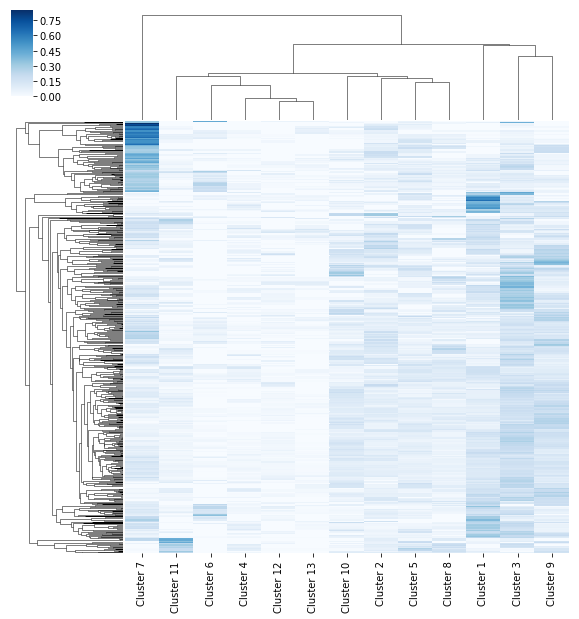

In [11]:
i = 0
k = 'Cluster 3'
meta_vals = []

for l in tqdm_notebook(lg1.get_leaves()):
    
    path = []
    node = l
    while node.up:
        try:
            path.append(node.cluster_count[k])
            node= node.up
        except:
            node= node.up
            continue
        
        
    meta_vals.append(path)

# for v in lg1.traverse('preorder'):
    
#     try:
# #         h = plt.figure(figsize = (5,5))
# #         plt.bar(v.cluster_count.keys(), v.cluster_count.values())
# #         plt.title(str(len(v.get_leaves())) + " cells")
# #         plt.xticks(rotation = 45, ha='right')
# #         plt.show()

# #         if i == 10:
# #             break

# #         i += 1
#         cluster1.append(v.cluster_count['Cluster 1'])
#     except:
#         continue

summ_dict = {}
keys = adata.obs['VISION_Clusters'].unique()
print(keys)
for v in lg1.traverse():
    try:
        summ_dict[v.name] = [v.cluster_count[k] for k in keys]
    except:
        continue
        
summ_df = pd.DataFrame.from_dict(summ_dict, orient='index')
summ_df.columns = keys

h = plt.figure(figsize = (10, 10))
sns.clustermap(summ_df, cmap = 'Blues', yticklabels = False)

interesting_paths = []
for v in lg1.traverse():
    try:
        if v.cluster_count['Cluster 7'] > 0.7:
            np = []
            node = v
            while node.up:
                path.append(node)
                node = node.up
            interesting_paths.append(path[::-1])
    except:
        continue

In [ ]:
adata.obs['selection'] = adata.obs.apply(lambda x: '1' if x.LineageGroup == 2 else '0', axis=1)
print(adata.obs['selection'].unique())
cmapping = {'1': 'red', '0': 'grey'}
plt.scatter(adata.obsm['X_umap']['UMAP-1'], adata.obsm['X_umap']['UMAP-2'], s=10000 / adata.shape[0], c = [cmapping[x] for x in adata.obs['selection']])

['0' '1']


7


Trying to set attribute `.obs` of view, making a copy.


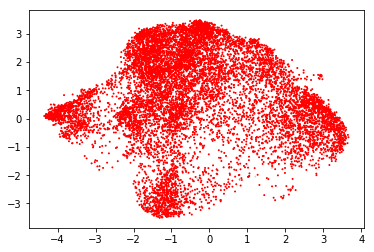

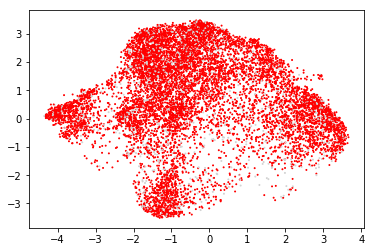

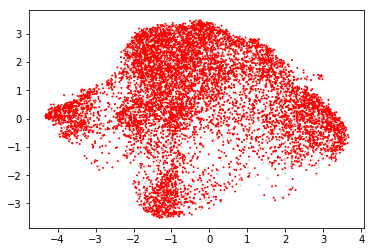

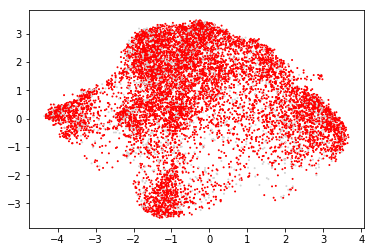

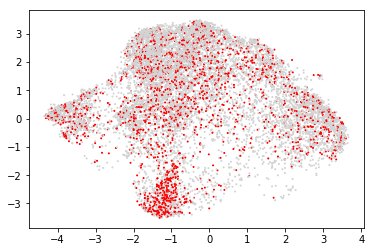

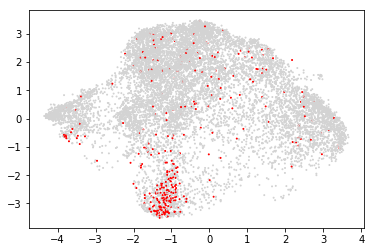

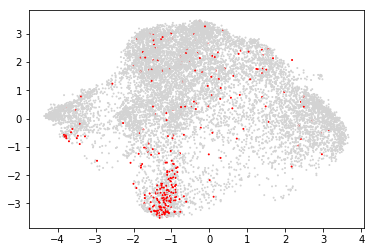

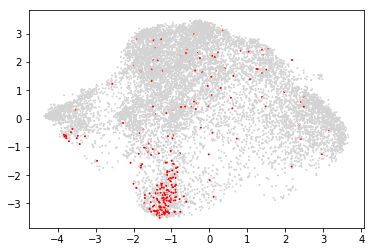

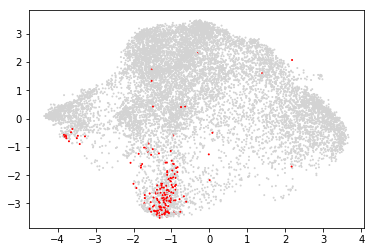

AttributeError: 'numpy.float64' object has no attribute 'get_leaf_names'

In [147]:
print(len(interesting_paths))
path = interesting_paths[0]
adata_lg1 = adata[adata.obs['LineageGroup'] == 1.0, :]
for p in path:
    children = p.get_leaf_names()
    adata_lg1.obs['selection'] = adata_lg1.obs.apply(lambda x: '1' if x.name in children else '0', axis=1)
    cmapping = {'1': 'red', '0': 'lightgrey'}
    plt.scatter(adata_lg1.obsm['X_umap']['UMAP-1'], adata_lg1.obsm['X_umap']['UMAP-2'], s=10000 / adata_lg1.shape[0], c = [cmapping[x] for x in adata_lg1.obs['selection']])
    plt.show()